<a href="https://colab.research.google.com/github/jearcher/bias-in-word-embeddings/blob/colab_style/Debias_Word_node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title
import numpy as np
from itertools import combinations, filterfalse
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
import random
import sys
import os
import pickle



In [5]:
# Update repo with any changes from github 
!git clone https://github.com/jearcher/bias-in-word-embeddings.git


Cloning into 'bias-in-word-embeddings'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 260 (delta 76), reused 226 (delta 48), pack-reused 0
Receiving objects: 100% (260/260), 20.17 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [6]:
# Pull colab specifi files
!cd '/content/bias-in-word-embeddings' && git checkout -B colab_style && git pull origin colab_style


Switched to a new branch 'colab_style'
From https://github.com/jearcher/bias-in-word-embeddings
 * branch            colab_style -> FETCH_HEAD
Updating 59fc8e8..e2751eb
Fast-forward
 ConceptorDebias/lists/load_word_lists.py |   16 +-
 Debias_Word2Vec.ipynb                    | 1233 +++++++++++++++++++++---------
 Debias_Word_node2Vec.ipynb               |  901 ++++++++++++++++++++++
 3 files changed, 1789 insertions(+), 361 deletions(-)
 create mode 100644 Debias_Word_node2Vec.ipynb


In [7]:
sys.path.append('/content/bias-in-word-embeddings')
sys.path.append('/content/bias-in-word-embeddings/ConceptorDebias')

In [8]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/bias-in-word-embeddings',
 '/content/bias-in-word-embeddings/ConceptorDebias']

In [9]:
# Helper functions

# Import local functions
from WEAT_functions import *
from Other_fxns import *


## Load Word Lists used for Debias

In [10]:
# Conceptor Debias word lists /content/bias-in-word-embeddings/enwiki-20190320-words-frequency.txt
sys.path.append('./')
from lists.load_word_lists import *



## Load Word2Vec into Gensim Object

In [11]:
!cd /content/bias-in-word-embeddings && mkdir data

In [12]:
!cd /content/bias-in-word-embeddings/data && mkdir embeddings

In [13]:
!cd /content/bias-in-word-embeddings/data/embeddings/ && mkdir Word-node2Vec

In [14]:
!cd /content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/ && curl -O https://storage.googleapis.com/word-embedding-bias/Word-Node2Vec_2019/dbpedia.cwvec12.200.bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.4M  100 45.4M    0     0  34.5M      0  0:00:01  0:00:01 --:--:-- 34.5M


In [15]:
Word_node2Vec = KeyedVectors.load_word2vec_format('/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/dbpedia.cwvec12.200.bin', 
                                          binary = True)

print("Word-node2Vec embedding has been loaded.")


Word-node2Vec embedding has been loaded.


## Combine lists for WEAT evaluation


In [16]:
"""Load list of pronouns representing the 'Pronoun' subspace for gender debiasing"""
gender_list_pronouns = WEATLists.W_7_Male_terms + WEATLists.W_7_Female_terms + WEATLists.W_8_Male_terms + WEATLists.W_8_Female_terms
gender_list_pronouns = list(set(gender_list_pronouns))

"""Load an extended list of words representing the gender subspace for gender debiasing"""
gender_list_extended = male_vino_extra + female_vino_extra + male_gnGlove + female_gnGlove
gender_list_extended = list(set(gender_list_extended))

"""Load list of proper nouns representing the 'Proper Noun' subspace for gender debiasing"""
gender_list_propernouns = male_cmu + female_cmu
gender_list_propernouns = list(set(gender_list_propernouns))

"""Load list of all representing the gender subspace for gender debiasing"""
gender_list_all = gender_list_pronouns + gender_list_extended + gender_list_propernouns
gender_list_all = list(set(gender_list_all))

"""Load list of common black and white names for racial debiasing"""
race_list = WEATLists.W_3_Unused_full_list_European_American_names + WEATLists.W_3_European_American_names + WEATLists.W_3_Unused_full_list_African_American_names + WEATLists.W_3_African_American_names + WEATLists.W_4_Unused_full_list_European_American_names + WEATLists.W_4_European_American_names + WEATLists.W_4_Unused_full_list_African_American_names + WEATLists.W_4_African_American_names + WEATLists.W_5_Unused_full_list_European_American_names + WEATLists.W_5_European_American_names + WEATLists.W_5_Unused_full_list_African_American_names + WEATLists.W_5_African_American_names 
race_list = list(set(race_list))

## Initialize Variables

In [17]:
resourceFile = ''
wikiWordsPath = resourceFile + '/content/bias-in-word-embeddings/SIF/auxiliary_data/enwiki_vocab_min200.txt' # https://github.com/PrincetonML/SIF/blob/master/auxiliary_data/enwiki_vocab_min200.txt

"""Set the embedding to be used"""
embd = 'Word_node2Vec'

"""Set the subspace to be tested on"""
subspace = 'gender_list_all' 

"""Load association and target word pairs"""
X = WEATLists.W_8_Science
Y = WEATLists.W_8_Arts
A = WEATLists.W_8_Male_terms
B = WEATLists.W_8_Female_terms

In [18]:
eval(embd)

In [19]:
curr_embd = eval(embd)
all_words_index, all_words_mat = load_all_vectors(curr_embd, wikiWordsPath)

## Compute Conceptor

In [20]:
"""Load the vectors for the words representing the subspace as a matrix and compute the respetive conceptor matrix"""
if subspace != 'without_conceptor':
  subspace_words_list = eval(subspace)
  if subspace == 'gender_list_and':
    if embd == 'elmo':
      subspace_words_mat1 = load_subspace_vectors_contextual(all_words_mat, all_words_index, gender_list_pronouns)
      cn1 = process_cn_matrix(np.array(subspace_words_mat1).T, alpha = 8)

      subspace_words_mat2 = load_subspace_vectors_contextual(all_words_mat, all_words_index, gender_list_extended)
      cn2 = process_cn_matrix(np.array(subspace_words_mat2).T, alpha = 3)

      subspace_words_mat3 = load_subspace_vectors_contextual(all_words_mat, all_words_index, gender_list_propernouns)
      cn3 = process_cn_matrix(np.array(subspace_words_mat3).T, alpha = 10)

      cn = AND(cn1, AND(cn2, cn3))
    elif embd == 'bert':
      cn1 = load_bert_conceptor(all_dict, gender_list_pronouns)
      
      cn2 = load_bert_conceptor(all_dict, gender_list_extended)
      
      cn3 = load_bert_conceptor(all_dict, gender_list_propernouns)
      
      cn = AND(cn1, AND(cn2, cn3))
    else:
      subspace_words_mat1 = load_subspace_vectors(curr_embd, gender_list_pronouns)
      cn1 = process_cn_matrix(np.array(subspace_words_mat1).T)

      subspace_words_mat2 = load_subspace_vectors(curr_embd, gender_list_extended)
      cn2 = process_cn_matrix(np.array(subspace_words_mat2).T)

      subspace_words_mat3 = load_subspace_vectors(curr_embd, gender_list_propernouns)
      cn3 = process_cn_matrix(np.array(subspace_words_mat3).T)

      cn = AND(cn1, AND(cn2, cn3))
  else: 
    if embd == 'elmo':
      subspace_words_mat = load_subspace_vectors_contextual(all_words_mat, all_words_index, subspace_words_list)
      cn = process_cn_matrix(np.array(subspace_words_mat).T, alpha = 6)
    elif embd == 'bert':
      cn = load_bert_conceptor(all_dict, subspace)
    else:
      subspace_words_mat = load_subspace_vectors(curr_embd, subspace_words_list)
      cn = process_cn_matrix(np.array(subspace_words_mat).T)

starting...
(200, 255)
R calculated
C calculated


## Compute Conceptored Embeddings


In [21]:
"""Conceptor all embeddings"""
all_words_cn = apply_conceptor(np.array(all_words_mat).T, np.array(cn))

"""Store all conceptored words in a dictonary"""
all_words = {}
for word, index in all_words_index.items():
  if embd == 'elmo':
    all_words[word] = np.mean([all_words_cn[i,:] for i in index], axis = 0)
  else:
    all_words[word] = all_words_cn[index,:]

In [40]:
# Convert to text to save 
def convert_to_text(curr_embd, saveto):
  for key, value in curr_embd.items():
    f = open("/content/" + saveto, "a+")
    val = ' '.join((np.array2string(value).replace("[","").replace("]","")).split()) + "\n"
    f.write(key + " " + val)
    

convert_to_text(all_words, "bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt")


## Calculate WEAT

In [22]:
# Before Debias 
pre = weat_effect_size(X, Y, A, B, Word_node2Vec)

d = weat_effect_size(X, Y, A, B, all_words)
# p = weat_p_value(X, Y, A, B, all_words, 1000)

print('WEAT on original Word-node2Vec = ', pre)
print('WEAT on Debias Word-node2Vec = ', d)

WEAT on original Word-node2Vec =  1.1809115
WEAT on Debias Word-node2Vec =  1.0103018742356074


# Visualize embeddings using PCA

In [23]:
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.decomposition import PCA

In [24]:
terms = WEATLists.W_8_Science + WEATLists.W_8_Arts + gender_list_pronouns
terms.remove('Einstein')
terms.remove("NASA")
terms.remove('Shakespeare')
terms.remove('novel')
terms.remove('he')
terms.remove('she')
terms.remove('her')
terms.remove('him')
terms.remove('his')
terms.remove('hers')

small_embedding = [Word_node2Vec[term] for term in terms ]
pca = PCA(n_components=2)
data = pca.fit_transform(small_embedding).transpose()
x, y = data[0], data[1]

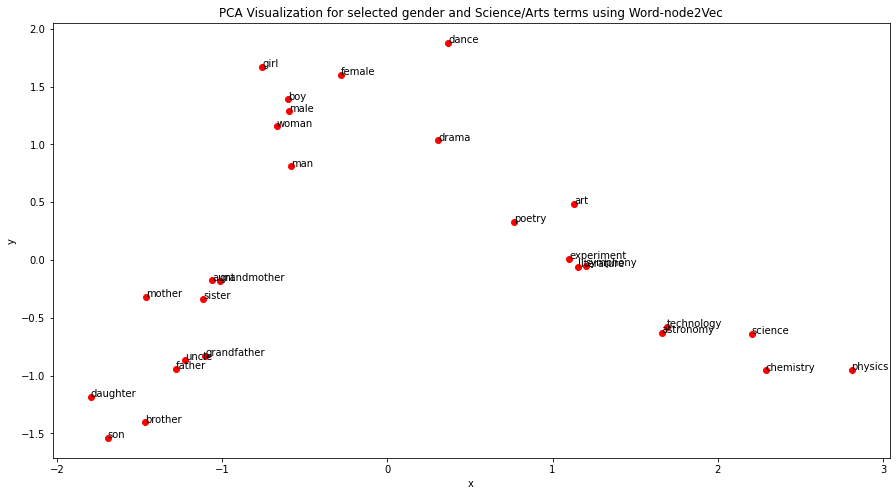

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x, y, c='r')
for i, term in enumerate(terms):
    ax.annotate(term, (x[i], y[i]))
plt.xlabel('x')
plt.ylabel('y')
plt.title("PCA Visualization for selected gender and Science/Arts terms using Word-node2Vec")
plt.show()

In [26]:
small_embedding_debias = [value for key, value in all_words.items() if key in terms]
pca_debias = PCA(n_components=2)
data_debias = pca_debias.fit_transform(small_embedding_debias).transpose()
x_debias, y_debias = data_debias[0], data_debias[1]

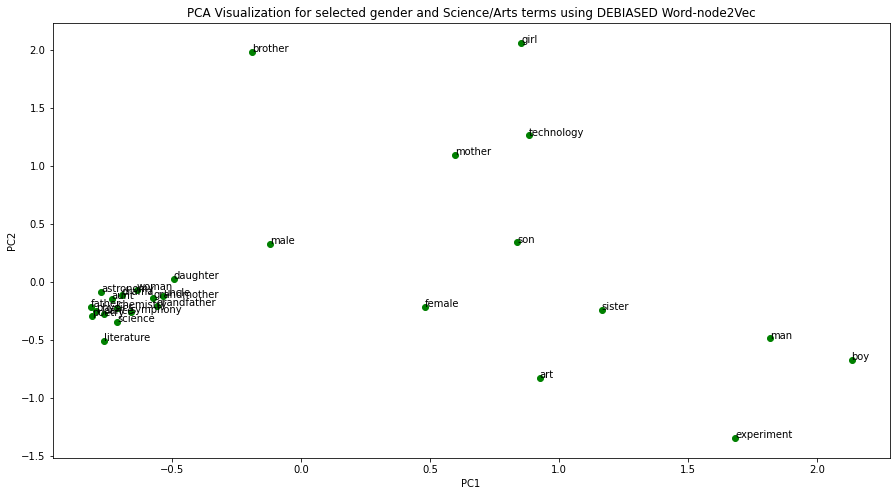

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x_debias, y_debias, c='g')
for i, term in enumerate(terms):
  if i<35:
    ax.annotate(term, (x_debias[i], y_debias[i]))
  continue
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Visualization for selected gender and Science/Arts terms using DEBIASED Word-node2Vec")

plt.show()

In [28]:
# What is most similar to 'woman' and 'king' but not similar to 'man'

Word_node2Vec.most_similar(positive=['woman', 'king'], negative=['man'])

[('regent', 0.521192729473114),
 ('consort', 0.5145156979560852),
 ('regnant', 0.49781352281570435),
 ('queen', 0.4850449562072754),
 ('reign', 0.4782247543334961),
 ('reigned', 0.4746331572532654),
 ('throne', 0.4692186415195465),
 ('ruled', 0.4668368399143219),
 ('prince', 0.4646092653274536),
 ('casimir', 0.46369442343711853)]

0.5696044

In [108]:
# Convert debiased embeddings to pandas df
df = pd.DataFrame(list(all_words.items())) 
df2 = df[1].apply(pd.Series) 
Word_node2Vec_debias = pd.concat([df[0], df2], axis=1)
# Word_node2Vec_debias.head()


# my_header ="{} {}\n".format(len(Word_node2Vec_debias), len(Word_node2Vec_debias.columns))
# #Word_node2Vec_debias.shape
# #line_prepender("/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt",
#                #header)

# np.savetxt("/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt",
#            Word_node2Vec_debias.values, 
#            fmt='%.18e', delimiter="\t", 
#            header=my_header)  
            


In [121]:
np.savetxt("/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt",
           Word_node2Vec_debias.values, 
           fmt='%s', delimiter=" ") 

In [140]:
np.savetxt('/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt',
           Word_node2Vec_debias.values, 
           delimiter=" ", 
           header="{} {}".format(len(Word_node2Vec_debias), (len(Word_node2Vec_debias.columns)-1)),
           comments="",
           fmt="%s")

In [141]:
# add
# "50897	200"
# to first line
Word_node2Vec_debias_gm = KeyedVectors.load_word2vec_format('/content/bias-in-word-embeddings/data/embeddings/Word-node2Vec/Word-node2Vec_debias.txt')


In [147]:
Word_node2Vec.similarity('man', 'king')


0.25837347

In [148]:
Word_node2Vec_debias_gm.similarity('man', 'king')


-0.024329955